In [1]:
!nvidia-smi
!cat /proc/cpuinfo | grep "model name"

/bin/bash: line 1: nvidia-smi: command not found
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn.preprocessing import MinMaxScaler

taxi_df = pd.read_csv('/content/drive/MyDrive/dataset_classification.csv')
print(taxi_df.info())
print(taxi_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413365 entries, 0 to 5413364
Data columns (total 30 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   passenger_count        float64
 1   trip_distance          float64
 2   PULocationID           int64  
 3   DOLocationID           int64  
 4   fare_amount            float64
 5   extra                  float64
 6   mta_tax                float64
 7   tolls_amount           float64
 8   improvement_surcharge  float64
 9   total_amount           float64
 10  congestion_surcharge   float64
 11  trip_duration          float64
 12  fare_per_mile          float64
 13  RatecodeID_1.0         bool   
 14  RatecodeID_2.0         bool   
 15  RatecodeID_3.0         bool   
 16  RatecodeID_4.0         bool   
 17  RatecodeID_5.0         bool   
 18  RatecodeID_6.0         bool   
 19  RatecodeID_99.0        bool   
 20  VendorID_1.0           bool   
 21  VendorID_2.0           bool   
 22  day_of_week_Friday

In [4]:
# Filtra i dati in base alla nuova colonna 'tipped'
h_tip = taxi_df[taxi_df['tipped'] == 1]
l_tip = taxi_df[taxi_df['tipped'] == 0]

print("tip: ", len(h_tip), " no_tip: ", len(l_tip))

# Bilancia il DataFrame
#balanced_df = pd.concat([l_tip, h_tip.sample(len(l_tip))])
balanced_df = pd.concat([l_tip.sample(10000), h_tip.sample(10000)])
#Daaset per la validazione
val_df = pd.concat([l_tip.sample(500000), h_tip.sample(500000)])
x_val = val_df.drop(columns=['tipped','PULocationID','DOLocationID'])
#'RatecodeID_1.0','RatecodeID_2.0','RatecodeID_3.0','RatecodeID_4.0','RatecodeID_5.0','RatecodeID_6.0','RatecodeID_99.0'

y_val = val_df['tipped']
# Rimuovi la colonna 'tip_amount'
print(len(balanced_df))

# Definisci le variabili X e y
x = balanced_df.drop(columns=['tipped','PULocationID','DOLocationID'])
y = balanced_df['tipped']



tip:  3919108  no_tip:  1494257
20000


In [5]:
from sklearn.model_selection import train_test_split
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(16000, 27)
(4000, 27)
(16000,)
(4000,)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.ensemble import GradientBoostingClassifier


# List of classifiers:
classifiers = [
    LogisticRegression(random_state = rs, n_jobs=-1),
    DecisionTreeClassifier(random_state=rs),
    GradientBoostingClassifier(n_estimators=50, random_state=rs),
    RandomForestClassifier(n_estimators = 10, random_state=rs,n_jobs=-1),
    SVC(kernel='linear',probability=True,C=0.1, random_state=rs)
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

In [7]:
for clf in classifiers:
  # Training the algorithms and results
  name = clf.__class__.__name__
  clf_name.append(name)

  #fitting and predictions
  model = clf.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  model_results[name] = y_pred

  #accuracy and log loss
  cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
  acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
  train_pred = clf.predict_proba(x_test)
  print(f'Accuracy: {acc} \t ---> {name} ')

  #confusion matrix, clasification report, roc curve
  cnfm.append(confusion_matrix(y_test, y_pred))
  clr.append(classification_report(y_test, y_pred))
  fpr, tpr, thresholds = roc_curve(y_pred, y_test)
  roc_auc.append(auc(fpr, tpr))
  roc_tpr.append(tpr)
  roc_fpr.append(fpr)


  ##################### CONTROLLO OVERFITTING #######################
  train_acc = model.score(x_train, y_train)  # Accuratezza sul training set
  test_acc = model.score(x_test, y_test)  # Accuratezza sul test set

  print(f"Train Accuracy: {train_acc:.2f}")
  print(f"Test Accuracy: {test_acc:.2f}")

  val_pred = model.predict(x_val)
  val_acc = accuracy_score(y_val, val_pred)
  print(f"Validation Accuracy: {val_acc:.2f}")

'''
  train_sizes, train_scores, test_scores = learning_curve(
      model, x, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy'
  )

  # Calcola medie e deviazioni standard
  train_mean = train_scores.mean(axis=1)
  train_std = train_scores.std(axis=1)
  test_mean = test_scores.mean(axis=1)
  test_std = test_scores.std(axis=1)

  # Visualizzazione
  plt.figure()
  plt.plot(train_sizes, train_mean, label='Training accuracy')
  plt.plot(train_sizes, test_mean, label='Test accuracy')
  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
  plt.legend()
  plt.xlabel('Training Set Size')
  plt.ylabel('Accuracy')
  plt.title(f'{name} Learning Curve')
  plt.show()

'''

Accuracy: 0.96 	 ---> LogisticRegression 
Train Accuracy: 0.96
Test Accuracy: 0.96
Validation Accuracy: 0.96
Accuracy: 0.97 	 ---> DecisionTreeClassifier 
Train Accuracy: 1.00
Test Accuracy: 0.97
Validation Accuracy: 0.97
Accuracy: 0.94 	 ---> GradientBoostingClassifier 
Train Accuracy: 0.94
Test Accuracy: 0.94
Validation Accuracy: 0.94
Accuracy: 0.95 	 ---> RandomForestClassifier 
Train Accuracy: 1.00
Test Accuracy: 0.95
Validation Accuracy: 0.95
Accuracy: 0.93 	 ---> SVC 
Train Accuracy: 0.93
Test Accuracy: 0.93
Validation Accuracy: 0.93


"\n  train_sizes, train_scores, test_scores = learning_curve(\n      model, x, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy'\n  )\n\n  # Calcola medie e deviazioni standard\n  train_mean = train_scores.mean(axis=1)\n  train_std = train_scores.std(axis=1)\n  test_mean = test_scores.mean(axis=1)\n  test_std = test_scores.std(axis=1)\n\n  # Visualizzazione\n  plt.figure()\n  plt.plot(train_sizes, train_mean, label='Training accuracy')\n  plt.plot(train_sizes, test_mean, label='Test accuracy')\n  plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)\n  plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)\n  plt.legend()\n  plt.xlabel('Training Set Size')\n  plt.ylabel('Accuracy')\n  plt.title(f'{name} Learning Curve')\n  plt.show()\n\n"

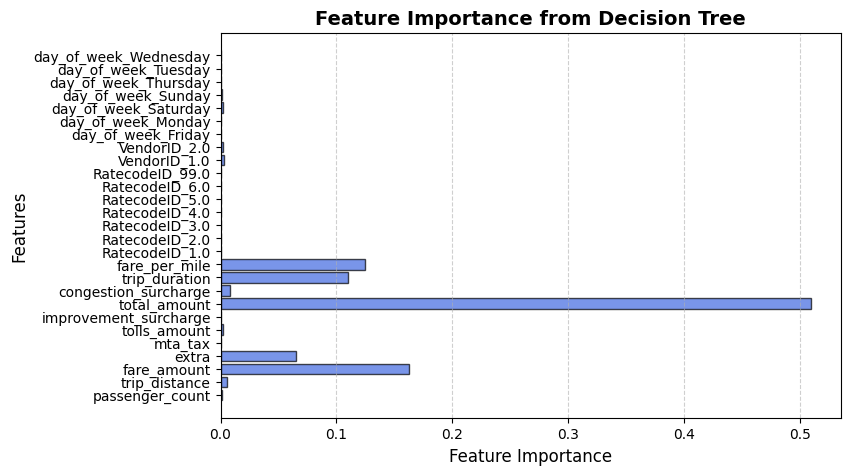

In [8]:
rf = DecisionTreeClassifier()
rf.fit(x, y)
importance = rf.feature_importances_

plt.figure(figsize=(8, 5))
plt.barh(x.columns, importance, color="royalblue", edgecolor="black", alpha=0.7)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance from Decision Tree", fontsize=14, fontweight='bold')
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

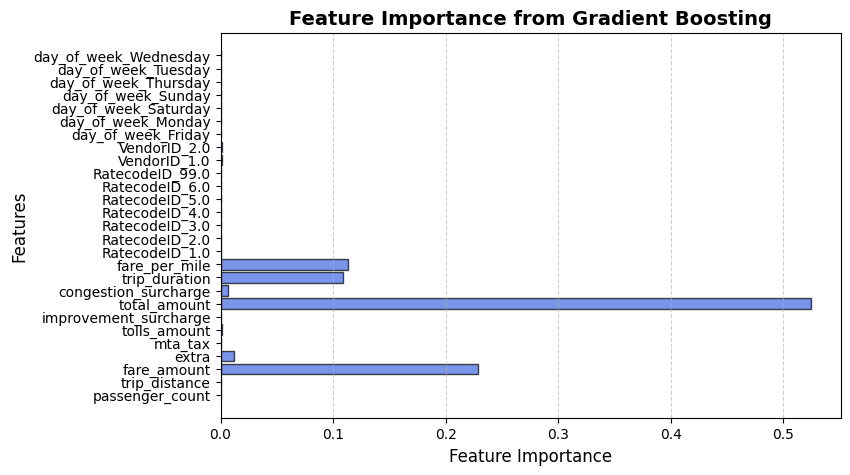

In [9]:
rf = GradientBoostingClassifier()
rf.fit(x, y)
importance = rf.feature_importances_

plt.figure(figsize=(8, 5))
plt.barh(x.columns, importance, color="royalblue", edgecolor="black", alpha=0.7)
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance from Gradient Boosting", fontsize=14, fontweight='bold')
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

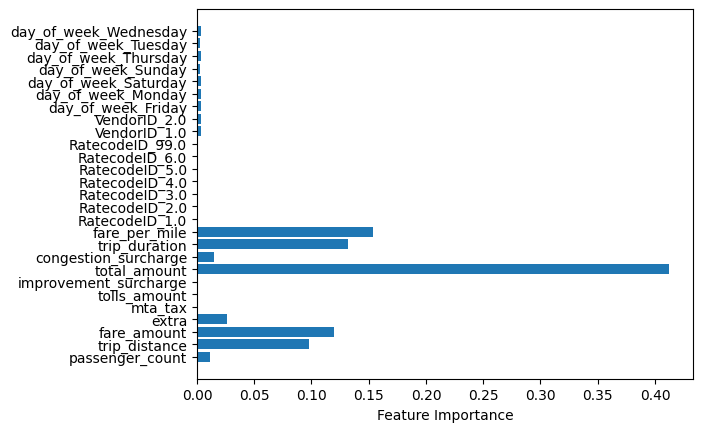

In [10]:


rf = RandomForestClassifier()
rf.fit(x, y)
importance = rf.feature_importances_

plt.barh(x.columns, importance)
plt.xlabel("Feature Importance")
plt.show()


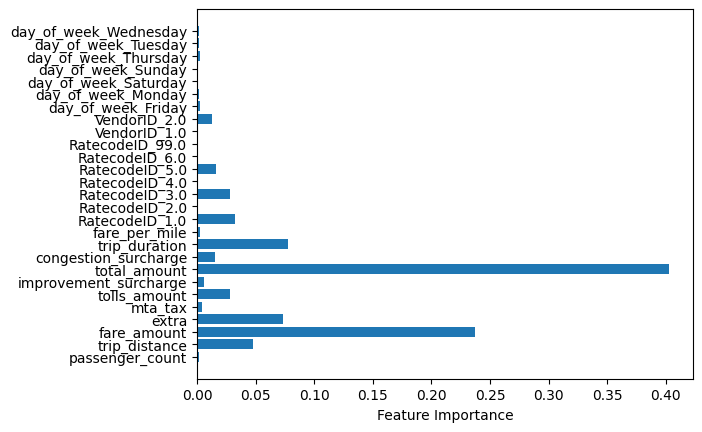

In [11]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x, y)
importance = abs(model.coef_[0])  # Valore assoluto dei coefficienti

# Normalizzazione (opzionale)
importance = importance / importance.sum()


plt.barh(x.columns, importance)
plt.xlabel("Feature Importance")
plt.show()


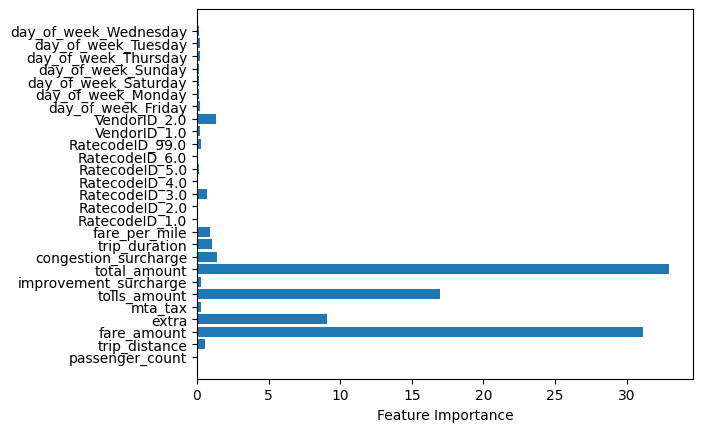

In [12]:

from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(x, y)
importance = abs(model.coef_[0])


plt.barh(x.columns, importance)
plt.xlabel("Feature Importance")
plt.show()

In [13]:
for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

In [14]:
# Cross validation accuracy results graph
print(cv_acc)
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})
cv_res.head()

[0.9585625, 0.9644999999999999, 0.9422499999999999, 0.9491250000000001, 0.9273125]


,CrossValMeans,CrossValerrors,Algorithm
0,0.958562,0.003363,LogisticRegression
1,0.964500,0.005269,DecisionTreeClassifier
2,0.942250,0.003482,GradientBoostingClassifier
3,0.949125,0.004733,RandomForestClassifier
4,0.927312,0.003825,SVC


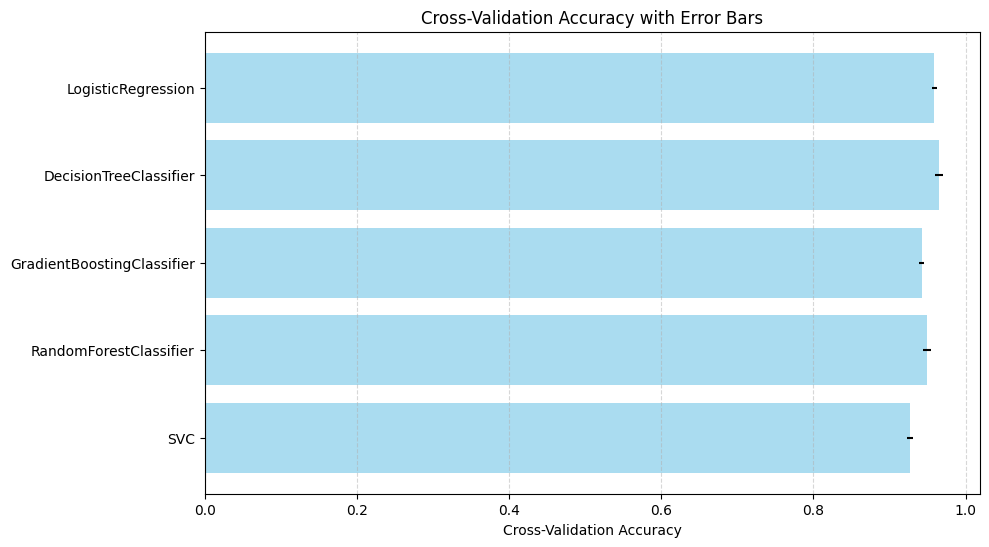

In [15]:
# Creazione dell'istogramma
plt.figure(figsize=(10, 6))
plt.barh(cv_res['Algorithm'], cv_res['CrossValMeans'], xerr=cv_res['CrossValerrors'], color='skyblue', alpha=0.7)
plt.xlabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy with Error Bars')
plt.gca().invert_yaxis()  # Invertiamo l'ordine per avere il miglior algoritmo in alto
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

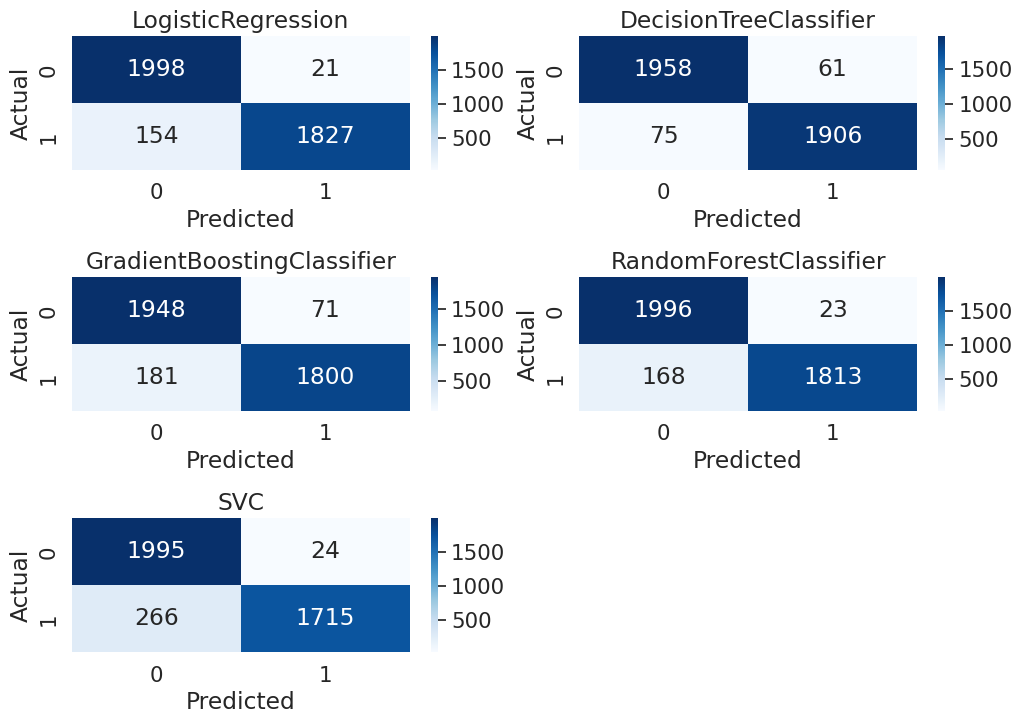

In [16]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplots_adjust(hspace=0.8)  # Modifica il valore per regolare lo spazio tra le righe
    plt.subplot(3,2,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

In [17]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" )
    print (clr[i])

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2019
           1       0.99      0.92      0.95      1981

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2019
           1       0.97      0.96      0.97      1981

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000

GradientBoostingClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2019
           1       0.96      0.91      0.93      1981

    accuracy                           0.94 

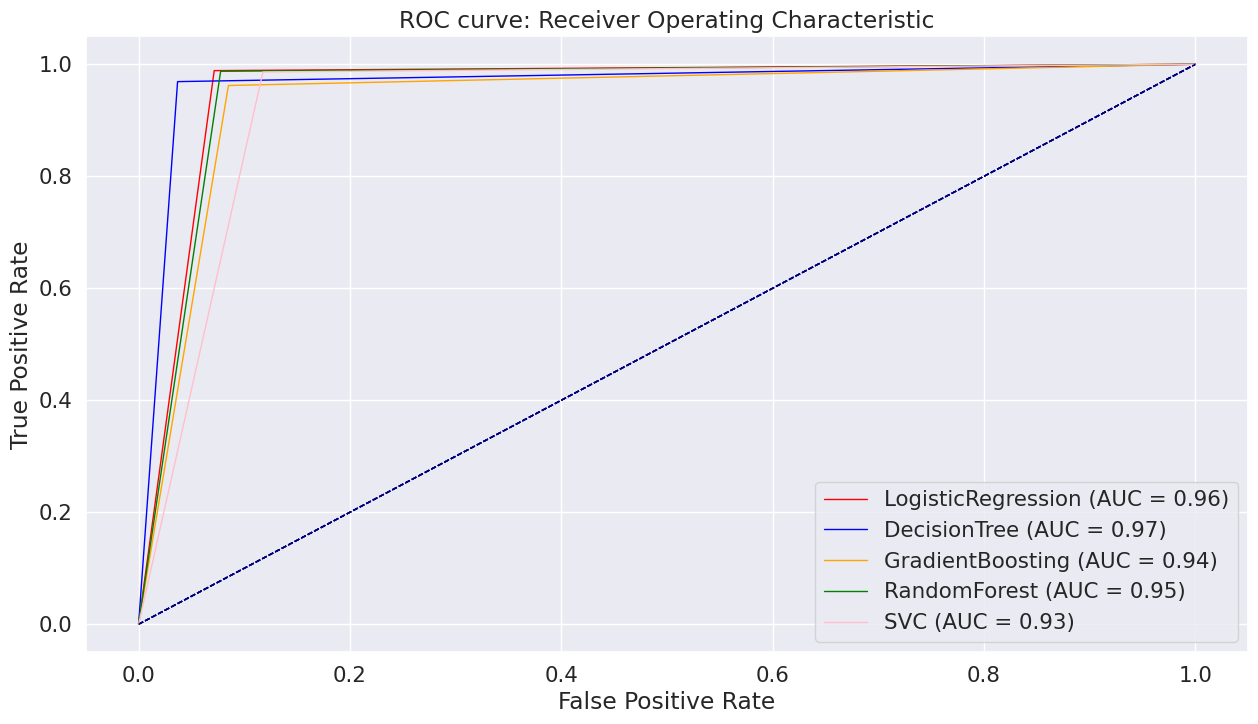

In [18]:
# ROC Curve
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [19]:
from sklearn.model_selection import GridSearchCV
# Search grid for optimal parameters

DT_param = {"max_depth": [2,3,8,10],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "criterion": ["gini"]}

RF_param = {"max_depth": [None],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [False],
            "n_estimators" :[100,300],
            "criterion": ["gini"]}

#using 4 n_jobs for faster processing
DTgs = GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
RFgs = GridSearchCV(RandomForestClassifier(), param_grid=RF_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)

models = [DTgs, RFgs]

gs_model = []
score = []

for model in models:
    model.fit(x_train, y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [20]:
# scores without gridsearch
print("score without GridSearchCV: ", round(cv_acc[1], 3), round(cv_acc[3], 3))
# scores with gridsearch
print("score with GridSearchCV: ", round(score[0], 3), round(score[1], 3))

score without GridSearchCV:  0.964 0.949
score with GridSearchCV:  0.952 0.98


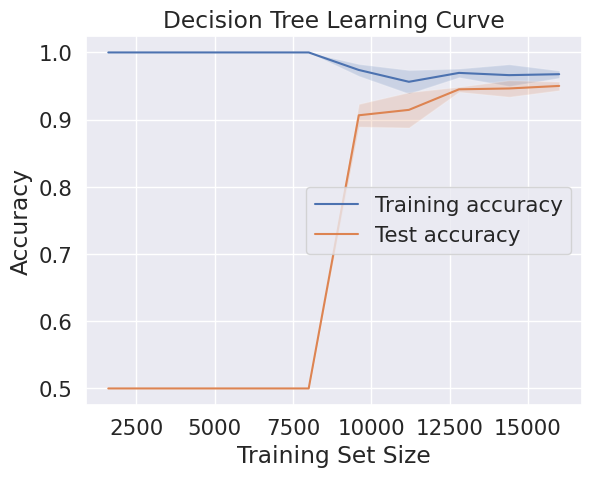

In [21]:
train_sizes, train_scores, test_scores = learning_curve(
      gs_model[0], x, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy'
  )

# Calcola medie e deviazioni standard
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Visualizzazione
plt.figure()
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.plot(train_sizes, test_mean, label='Test accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.legend()
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Decision Tree Learning Curve')
plt.show()

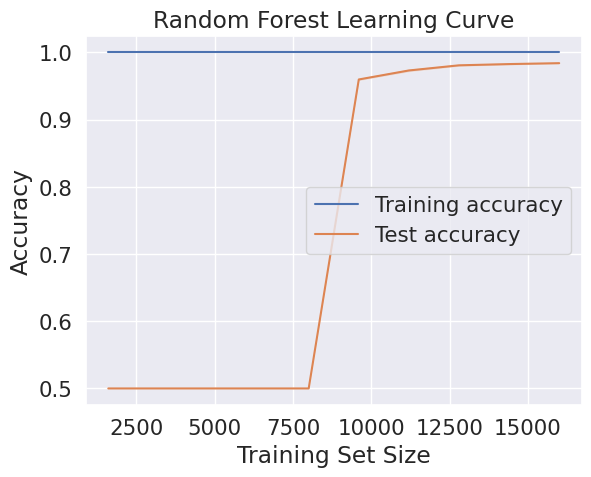

In [22]:
train_sizes, train_scores, test_scores = learning_curve(
      gs_model[1], x, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy'
  )

# Calcola medie e deviazioni standard
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Visualizzazione
plt.figure()
plt.plot(train_sizes, train_mean, label='Training accuracy')
plt.plot(train_sizes, test_mean, label='Test accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.legend()
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Random Forest Learning Curve')
plt.show()

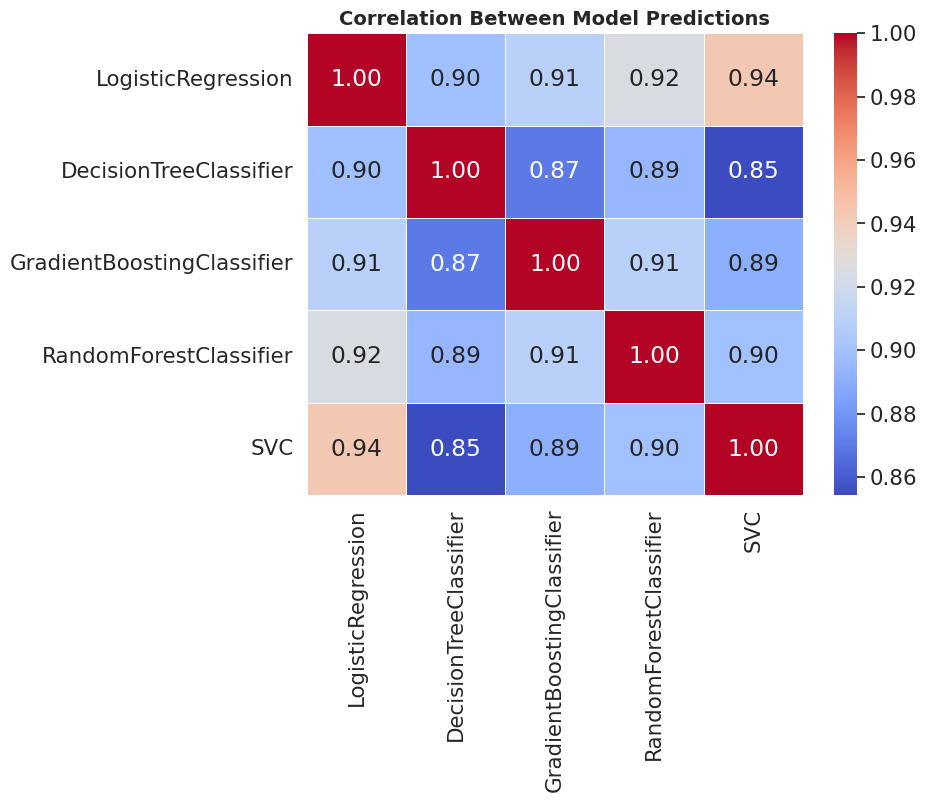

In [23]:
data = {
    'LogisticRegression': model_results["LogisticRegression"],
    'DecisionTreeClassifier': model_results["DecisionTreeClassifier"],
    'GradientBoostingClassifier': model_results["GradientBoostingClassifier"],
    'RandomForestClassifier': model_results["RandomForestClassifier"],
    'SVC': model_results["SVC"]
}
model_results_df = pd.DataFrame(data)

# Compute the correlation matrix
correlation_matrix = model_results_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Model Predictions", fontsize=14, fontweight='bold')
plt.show()

In [26]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Definizione dei parametri per Grid Search
SVC_param = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

GB_param = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 10]
}

# Creazione degli oggetti dei modelli
svc = SVC(probability=True)
gb = GradientBoostingClassifier()

# Grid Search per entrambi i modelli
gs_svc = GridSearchCV(svc, SVC_param, cv=5, scoring="accuracy", n_jobs=-1)
gs_gb = GridSearchCV(gb, GB_param, cv=5, scoring="accuracy", n_jobs=-1)

# Addestramento dei modelli
gs_svc.fit(x_train, y_train)
gs_gb.fit(x_train, y_train)

# Migliori modelli trovati
best_svc = gs_svc.best_estimator_
best_gb = gs_gb.best_estimator_

# Aggiornare il VotingClassifier con SVC e Gradient Boosting
best_model = VotingClassifier(estimators=[
    ('dt', gs_model[0]),
    ('rf', gs_model[1]),
    ('svc', best_svc),
    ('gb', best_gb)
], voting='soft', n_jobs=4)

# Addestramento del VotingClassifier
best_model.fit(x_train, y_train)
print(accuracy_score(y_test, best_model.predict(x_test)))

# Visualizzazione delle metriche
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC
from yellowbrick.model_selection import LearningCurve

plt.figure(figsize=(12,8))
visualizer = ROCAUC(best_model, classes=["not_survived", "survived"], micro=False, macro=False, binary=True)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()

plt.figure(figsize=(12,8))
viz = PrecisionRecallCurve(best_model)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)
visualizer.fit(x, y)
visualizer.show()


KeyboardInterrupt: 

0.98325


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


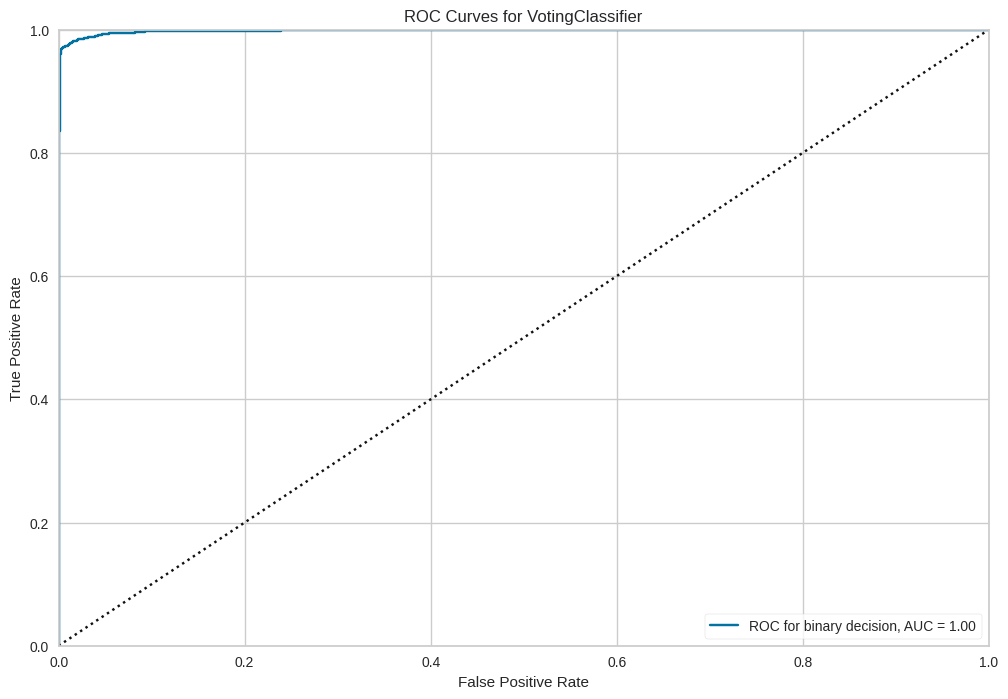

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


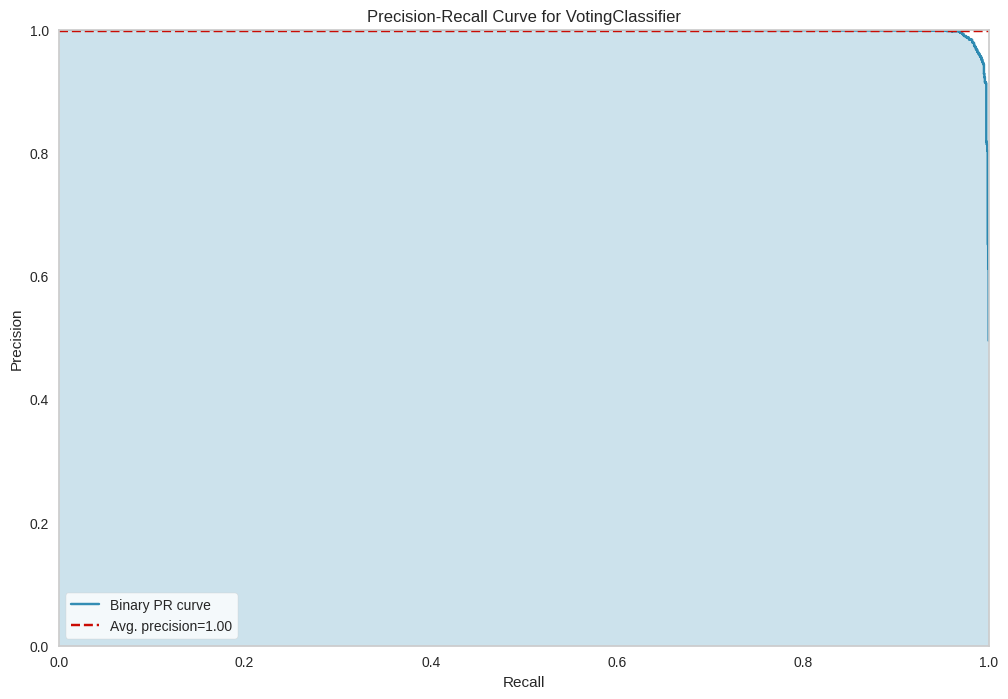

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/joblib/_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/joblib/parallel.py", line 598, in <listcomp>
    return [func(*a

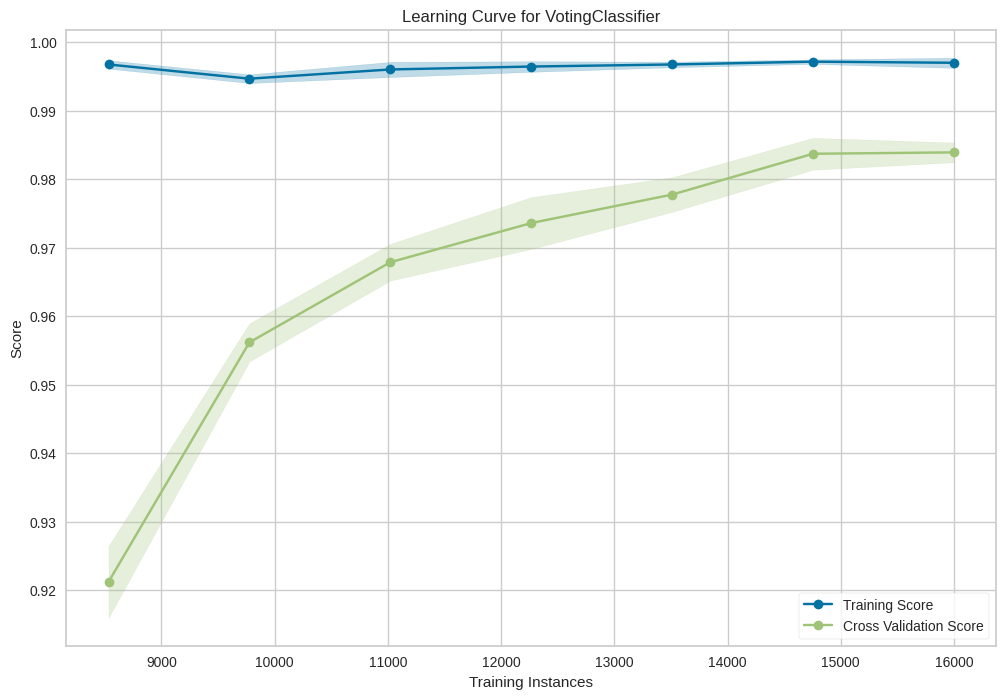

<Axes: title={'center': 'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [27]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Creazione dei modelli con parametri di default o valori scelti
svc = SVC(probability=True, kernel="rbf", C=1, gamma="scale")  # Modifica i parametri se necessario
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)  # Parametri scelti

# Aggiornare il VotingClassifier includendo SVC e Gradient Boosting
best_model = VotingClassifier(estimators=[
    ('dt', gs_model[0]),
    ('rf', gs_model[1]),
    ('svc', svc),
    ('gb', gb)
], voting='soft', n_jobs=4)

# Addestramento del VotingClassifier
best_model.fit(x_train, y_train)
print(accuracy_score(y_test, best_model.predict(x_test)))

# Visualizzazione delle metriche
from yellowbrick.classifier import PrecisionRecallCurve, ROCAUC
from yellowbrick.model_selection import LearningCurve

plt.figure(figsize=(12,8))
visualizer = ROCAUC(best_model, classes=["not_survived", "survived"], micro=False, macro=False, binary=True)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()

plt.figure(figsize=(12,8))
viz = PrecisionRecallCurve(best_model)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)
visualizer.fit(x, y)
visualizer.show()
